In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import statsmodels
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.statespace.sarimax import SARIMAX
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout
from sklearn.preprocessing import MinMaxScaler

In [2]:
df = pd.read_csv('../data/zillow_data.csv')
df

,RegionID,RegionName,City,State,Metro,CountyName,SizeRank,1996-04,1996-05,1996-06,...,2017-07,2017-08,2017-09,2017-10,2017-11,2017-12,2018-01,2018-02,2018-03,2018-04
0,84654,60657,Chicago,IL,Chicago,Cook,1,334200.0,335400.0,336500.0,...,1005500,1007500,1007800,1009600,1013300,1018700,1024400,1030700,1033800,1030600
1,90668,75070,McKinney,TX,Dallas-Fort Worth,Collin,2,235700.0,236900.0,236700.0,...,308000,310000,312500,314100,315000,316600,318100,319600,321100,321800
2,91982,77494,Katy,TX,Houston,Harris,3,210400.0,212200.0,212200.0,...,321000,320600,320200,320400,320800,321200,321200,323000,326900,329900
3,84616,60614,Chicago,IL,Chicago,Cook,4,498100.0,500900.0,503100.0,...,1289800,1287700,1287400,1291500,1296600,1299000,1302700,1306400,1308500,1307000
4,93144,79936,El Paso,TX,El Paso,El Paso,5,77300.0,77300.0,77300.0,...,119100,119400,120000,120300,120300,120300,120300,120500,121000,121500
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14718,58333,1338,Ashfield,MA,Greenfield Town,Franklin,14719,94600.0,94300.0,94000.0,...,216800,217700,218600,218500,218100,216400,213100,209800,209200,209300
14719,59107,3293,Woodstock,NH,Claremont,Grafton,14720,92700.0,92500.0,92400.0,...,202100,208400,212200,215200,214300,213100,213700,218300,222700,225800
14720,75672,40404,Berea,KY,Richmond,Madison,14721,57100.0,57300.0,57500.0,...,121800,122800,124600,126700,128800,130600,131700,132500,133000,133400
14721,93733,81225,Mount Crested Butte,CO,NaN,Gunnison,14722,191100.0,192400.0,193700.0,...,662800,671200,682400,695600,695500,694700,706400,705300,681500,664400


In [3]:
df_time_series = pd.DataFrame(index=pd.to_datetime(df.columns[7:]), data=np.ones(len(df.columns)-7))
for i in range(df.shape[0]):
    df_time_series[df['RegionID'][i]] = df.iloc[i,7:]
df_time_series.drop(df_time_series.columns[0],axis=1, inplace=True)
df_time_series

,84654,90668,91982,84616,93144,91733,61807,84640,91940,97564,...,59187,94711,62556,99032,62697,58333,59107,75672,93733,95851
1996-04-01,334200,235700,210400,498100,77300,95000,152900,216500,95400,766000,...,80800,135900,78300,136200,62500,94600,92700,57100,191100,176400
1996-05-01,335400,236900,212200,500900,77300,95200,152700,216700,95600,771100,...,80100,136300,78300,136600,62600,94300,92500,57300,192400,176300
1996-06-01,336500,236700,212200,503100,77300,95400,152600,216900,95800,776500,...,79400,136600,78200,136800,62700,94000,92400,57500,193700,176100
1996-07-01,337600,235400,210700,504600,77300,95700,152400,217000,96100,781900,...,78600,136900,78200,136800,62700,93700,92200,57700,195000,176000
1996-08-01,338500,233300,208300,505500,77400,95900,152300,217100,96400,787300,...,77900,137100,78100,136700,62700,93400,92100,58000,196300,175900
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2017-12-01,1018700,316600,321200,1299000,120300,162800,414300,777900,172300,3778700,...,123400,257600,171300,341000,122800,216400,213100,130600,694700,348900
2018-01-01,1024400,318100,321200,1302700,120300,162800,413900,778500,173300,3770800,...,124400,258000,172400,342300,123200,213100,213700,131700,706400,350400
2018-02-01,1030700,319600,323000,1306400,120500,162900,411400,780500,174200,3763100,...,125500,260600,173600,345000,123200,209800,218300,132500,705300,353000
2018-03-01,1033800,321100,326900,1308500,121000,163500,413200,782800,175400,3779800,...,126600,264700,175800,348000,120700,209200,222700,133000,681500,356000


In [4]:
df_time_series.isna().sum().sum()

156891

In [5]:
df_nv = df[df['State'] == 'NV']
nv_zipcodes = list(df_nv.RegionID)
nv_zipcodes[0]

95804

In [6]:
df_time_series.fillna(method='bfill', inplace=True)

In [7]:
df_time_series.isna().sum().sum()

0

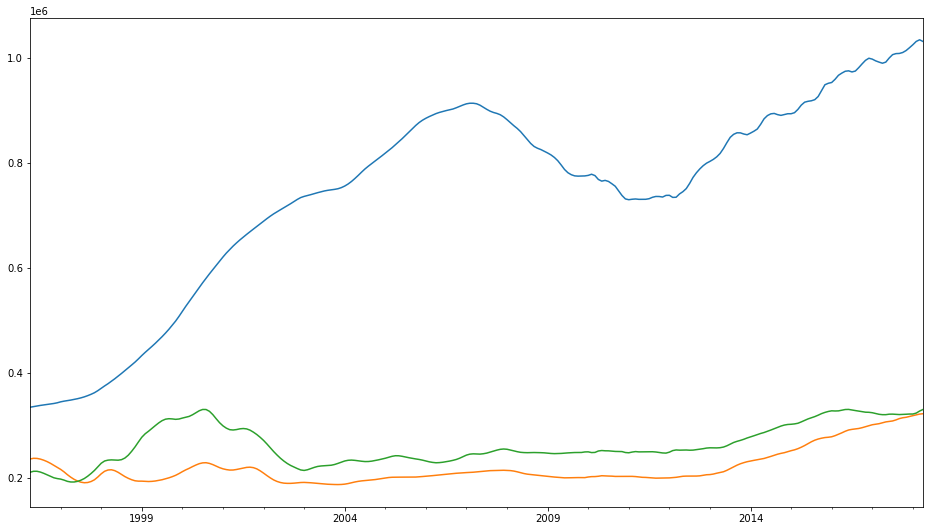

In [8]:
df_time_series.iloc[:,0].plot(figsize=(16,9))
df_time_series.iloc[:,1].plot()
df_time_series.iloc[:,2].plot();

# RNN Model

In [9]:
size = int(len(df_time_series)*.8)
train = df_time_series.iloc[:size]
test = df_time_series.iloc[size:]

In [10]:
df_time_series = df_time_series[nv_zipcodes]
train = train[nv_zipcodes]
test = test[nv_zipcodes]

We are trying a RNN model to see how it does on our first zipcode

In [11]:
x = 0
train_data = train.iloc[:,x:x+1].values.astype(int)
test_data = test.iloc[:,x:x+1].values.astype(int)

In [12]:
scaler = MinMaxScaler(feature_range=(0,1))
train_data_scaled = scaler.fit_transform(train_data)
test_data_scaled = scaler.fit_transform(test_data)

Creating a dataset with 60 timesteps (5 years)

In [13]:
X_train = []
y_train = []
for i in range(60,len(train_data_scaled)):
    X_train.append(train_data_scaled[i-60:i])
    y_train.append(train_data_scaled[i])

data_total = pd.concat((train.iloc[:,x:x+1], test.iloc[:,x:x+1]),axis=0)
inputs = data_total[len(train)-60:].values
inputs = scaler.transform(inputs)

X_test = []
y_test = []
for i in range(60,len(inputs)):
    X_test.append(inputs[i-60:i])
    y_test.append(inputs[i])
X_test = np.array(X_test)
y_test = np.array(test_data)

Turn data into arrays for RNN

In [14]:
X_train, y_train, X_test, y_test = np.array(X_train), np.array(y_train), np.array(X_test), np.array(y_test)

Initialize RNN Model

In [15]:
rnn_model = Sequential()

Building the LSTM layers

In [16]:
rnn_model.add(LSTM(units= 60, return_sequences = False, input_shape=((60,1))))


In [17]:
rnn_model.add(Dense(units=1))


In [18]:
rnn_model.compile(optimizer='adam', loss='mean_squared_error')

In [19]:
rnn_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 60)                14880     
_________________________________________________________________
dense (Dense)                (None, 1)                 61        
Total params: 14,941
Trainable params: 14,941
Non-trainable params: 0
_________________________________________________________________


In [20]:
rnn_model.fit(X_train, y_train, epochs=100, batch_size=32)


Epoch 1/100
5/5 [==============================] - 0s 13ms/step - loss: 0.1311
Epoch 2/100
5/5 [==============================] - 0s 11ms/step - loss: 0.0270
Epoch 3/100
5/5 [==============================] - 0s 10ms/step - loss: 0.0319
Epoch 4/100
5/5 [==============================] - 0s 10ms/step - loss: 0.0150
Epoch 5/100
5/5 [==============================] - 0s 11ms/step - loss: 0.0158
Epoch 6/100
5/5 [==============================] - 0s 10ms/step - loss: 0.0124
Epoch 7/100
5/5 [==============================] - 0s 11ms/step - loss: 0.0097
Epoch 8/100
5/5 [==============================] - 0s 10ms/step - loss: 0.0089
Epoch 9/100
5/5 [==============================] - 0s 10ms/step - loss: 0.0069
Epoch 10/100
5/5 [==============================] - 0s 10ms/step - loss: 0.0058
Epoch 11/100
5/5 [==============================] - 0s 10ms/step - loss: 0.0046
Epoch 12/100
5/5 [==============================] - 0s 10ms/step - loss: 0.0035
Epoch 13/100
5/5 [==============================]

In [21]:
y_hat_raw = rnn_model.predict(X_test)
y_hat = scaler.inverse_transform(y_hat_raw)

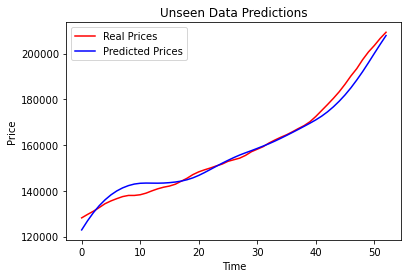

In [22]:
plt.plot(y_test, color='red', label='Real Prices')
plt.plot(y_hat, color='blue', label='Predicted Prices')
plt.title('Unseen Data Predictions')
plt.xlabel('Time')
plt.ylabel('Price')
plt.legend()
plt.show;

Using Our RNN model on all NV Zipcodes

In [23]:
zipcodes = nv_zipcodes
dict_mape = {}
dict_pred = {}

for zipcode in range(len(zipcodes)):

    # init a RMM model
    rnn_model = Sequential()
    # add 4 layers of RNN and a last layer

    # we define shape on first layer, (60,1) because we use 60 inputs per prediction
    rnn_model.add(LSTM(units= 60, return_sequences = False, input_shape=((60,1))))
    #rnn_model.add(Dropout(.1))

    # 3 other layers
    #rnn_model.add(LSTM(units= 30, return_sequences = True))
    #rnn_model.add(Dropout(.1))

    # return_sequence is False because we want only 1 output after this layer
    #rnn_model.add(LSTM(units= 60, return_sequences = False))
    #rnn_model.add(Dropout(.1))

    # last layer 

    rnn_model.add(Dense(units=1))

    # compile - because this is a regression model we want to minimize MSE

    rnn_model.compile(optimizer='adam', loss='mean_absolute_percentage_error')

    # We get only the specific column(Zipcode from our train and test datas)
    train_data = train.iloc[:,zipcode:zipcode+1].values.astype(int)
    test_data = test.iloc[:,zipcode:zipcode+1].values.astype(int)
    
    # We are using normalizaion rather than standascaler. 
    # In a upward trending timeseries it is better to not start from negative

    scaler = MinMaxScaler(feature_range=(0,1))
    train_data_scaled = scaler.fit_transform(train_data)
    test_data_scaled = scaler.transform(test_data)

    # Because we are using 60 previous values to model and predict the next value, 
    # We set X_train from arrays of 60 for each y_train value
    # Same idea for test data sets
    X_train = []
    y_train = []
    for i in range(60,len(train_data_scaled)):
        X_train.append(train_data_scaled[i-60:i])
        y_train.append(train_data_scaled[i])

    data_total = pd.concat((train.iloc[:,zipcode:zipcode+1], test.iloc[:,zipcode:zipcode+1]),axis=0)
    inputs = data_total[len(train)-60:].values
    inputs = scaler.transform(inputs)

    X_test = []
    y_test = []
    for i in range(60,len(inputs)):
        X_test.append(inputs[i-60:i])
        y_test.append(inputs[i])
    X_test = np.array(X_test)
    y_test = np.array(test_data)

    # We need numpy arrays for our model
    X_train, y_train, X_test, y_test = np.array(X_train), np.array(y_train), np.array(X_test), np.array(y_test)
    
    # We fit our data to our zipcode specific data
    rnn_model.fit(X_train, y_train, epochs=50, batch_size=32, validation_data=(X_test, scaler.transform(y_test)))

    # Make predictions on the data

    y_hat_raw = rnn_model.predict(X_test)
    y_hat = scaler.inverse_transform(y_hat_raw)

    # Use the score on unseen test data to calculate the MAPE

    dict_mape[zipcodes[zipcode]] = np.mean(np.absolute((y_hat-y_test)/y_test))      

    # We get the last 60 values from our test data which is basically last 60 values in the data set
    last_60 = df_time_series.iloc[-60:,zipcode:zipcode+1].values.astype(int)
    
    # Before we use our data we scale it
    last_60 = scaler.transform(last_60)
    
    # Our input should be in (x,60,1) format
    x_new_pred = last_60[-60:].reshape(1,60,1)

    # make a prediction, add to the last_60 for the next prediction and 
    y_pred = rnn_model.predict(x_new_pred)

    # We add our predition to our list of predictions for zipcode specific predictions list
    dict_pred[zipcodes[zipcode]]=scaler.inverse_transform(y_pred)
    
    print(f'Iteration number {zipcode} finished')
    

Epoch 1/50
5/5 [==============================] - 0s 79ms/step - loss: 24838.7852 - val_loss: 114.0518
Epoch 2/50
5/5 [==============================] - 0s 14ms/step - loss: 346162.7188 - val_loss: 119.8761
Epoch 3/50
5/5 [==============================] - 0s 14ms/step - loss: 311825.0938 - val_loss: 110.4996
Epoch 4/50
5/5 [==============================] - 0s 14ms/step - loss: 112270.8281 - val_loss: 104.1052
Epoch 5/50
5/5 [==============================] - 0s 14ms/step - loss: 7280.6343 - val_loss: 98.2523
Epoch 6/50
5/5 [==============================] - 0s 15ms/step - loss: 161654.6094 - val_loss: 95.9728
Epoch 7/50
5/5 [==============================] - 0s 22ms/step - loss: 156434.8594 - val_loss: 96.8727
Epoch 8/50
5/5 [==============================] - 0s 14ms/step - loss: 106218.5703 - val_loss: 99.1697
Epoch 9/50
5/5 [==============================] - 0s 14ms/step - loss: 59663.7812 - val_loss: 102.5557
Epoch 10/50
5/5 [==============================] - 0s 15ms/step - loss: 

In [24]:
rnn_keys = list(dict_mape.keys())
rnn_mape = list(dict_mape.values())
rnn_pred = []
rnn_dict = {}
for zipcode in dict_pred.keys():
    rnn_pred.append(dict_pred[zipcode].astype(int)[0][0])
for zc in rnn_keys:
    a = []
    a.append(dict_mape[zc])
    a.append(dict_pred[zc].astype(float)[0][0])
    a.append('RNN')
    rnn_dict[zc] = a

In [25]:
rnn_dict

{95804: [0.5249661853680645, 72680.1015625, 'RNN'],
 95817: [0.4872030385214798, 81155.828125, 'RNN'],
 95813: [0.008052491635078938, 343416.90625, 'RNN'],
 95785: [0.014499261495305815, 408869.96875, 'RNN'],
 95819: [0.020140183496271478, 299286.53125, 'RNN'],
 95770: [0.46004740014319195, 98583.3671875, 'RNN'],
 95806: [0.5511401233777548, 62497.55078125, 'RNN'],
 95790: [0.02367226537890664, 307056.4375, 'RNN'],
 95799: [0.41608277029750435, 110232.8046875, 'RNN'],
 95844: [0.013734452486544268, 298359.625, 'RNN'],
 95843: [0.39383061728555874, 133019.71875, 'RNN'],
 95815: [0.49980302429945644, 82623.078125, 'RNN'],
 95825: [0.3942505029359258, 138097.171875, 'RNN'],
 95818: [0.4399410165041235, 94415.8046875, 'RNN'],
 95811: [0.4545158547574294, 78562.640625, 'RNN'],
 95931: [0.4469864096516115, 115641.796875, 'RNN'],
 95753: [0.367702129081654, 151804.90625, 'RNN'],
 95827: [0.014149623323571657, 334876.96875, 'RNN'],
 95937: [0.01106950871377929, 443817.4375, 'RNN'],
 95914: [0.

In [26]:
np.mean(rnn_mape)

0.20516228703411893

In [27]:
zipcodes = nv_zipcodes
dict_mape2 = {}
dict_pred2 = {}

for zipcode in range(len(zipcodes)):

    # init a RMM model
    rnn_model2 = Sequential()
    # add 4 layers of RNN and a last layer

    # we define shape on first layer, (60,1) because we use 60 inputs per prediction
    rnn_model2.add(LSTM(units= 60, return_sequences = True, input_shape=((60,1))))
    #rnn_model.add(Dropout(.1))

    # another layer
    rnn_model2.add(LSTM(units= 30, return_sequences = False))
    #rnn_model.add(Dropout(.1))

    # return_sequence is False because we want only 1 output after this layer
    #rnn_model.add(LSTM(units= 60, return_sequences = False))
    #rnn_model.add(Dropout(.1))

    # last layer 

    rnn_model2.add(Dense(units=1))

    # compile - because this is a regression model we want to minimize MSE

    rnn_model2.compile(optimizer='adam', loss='mean_absolute_percentage_error')

    # We get only the specific column(Zipcode from our train and test datas)
    train_data = train.iloc[:,zipcode:zipcode+1].values.astype(int)
    test_data = test.iloc[:,zipcode:zipcode+1].values.astype(int)
    
    # We are using normalizaion rather than standascaler. 
    # In a upward trending timeseries it is better to not start from negative

    scaler = MinMaxScaler(feature_range=(0,1))
    train_data_scaled = scaler.fit_transform(train_data)
    test_data_scaled = scaler.transform(test_data)

    # Because we are using 60 previous values to model and predict the next value, 
    # We set X_train from arrays of 60 for each y_train value
    # Same idea for test data sets
    X_train = []
    y_train = []
    for i in range(60,len(train_data_scaled)):
        X_train.append(train_data_scaled[i-60:i])
        y_train.append(train_data_scaled[i])

    data_total = pd.concat((train.iloc[:,zipcode:zipcode+1], test.iloc[:,zipcode:zipcode+1]),axis=0)
    inputs = data_total[len(train)-60:].values
    inputs = scaler.transform(inputs)

    X_test = []
    y_test = []
    for i in range(60,len(inputs)):
        X_test.append(inputs[i-60:i])
        y_test.append(inputs[i])
    X_test = np.array(X_test)
    y_test = np.array(test_data)

    # We need numpy arrays for our model
    X_train, y_train, X_test, y_test = np.array(X_train), np.array(y_train), np.array(X_test), np.array(y_test)
    
    # We fit our data to our zipcode specific data
    rnn_model2.fit(X_train, y_train, epochs=50, batch_size=32, validation_data=(X_test, scaler.transform(y_test)))

    # Make predictions on the data

    y_hat_raw = rnn_model2.predict(X_test)
    y_hat = scaler.inverse_transform(y_hat_raw)

    # Use the score on unseen test data to calculate the MAPE

    dict_mape2[zipcodes[zipcode]] = np.mean(np.absolute((y_hat-y_test)/y_test))      

    # We get the last 60 values from our test data which is basically last 60 values in the data set
    last_60 = df_time_series.iloc[-60:,zipcode:zipcode+1].values.astype(int)
    
    # Before we use our data we scale it
    last_60 = scaler.transform(last_60)
    
    # Our input should be in (x,60,1) format
    x_new_pred = last_60[-60:].reshape(1,60,1)

    # make a prediction, add to the last_60 for the next prediction and 
    y_pred = rnn_model2.predict(x_new_pred)

    # We add our predition to our list of predictions for zipcode specific predictions list
    dict_pred2[zipcodes[zipcode]]=scaler.inverse_transform(y_pred)
    
    print(f'Iteration number {zipcode} finished')
    

Epoch 1/50
5/5 [==============================] - 1s 143ms/step - loss: 11875.9033 - val_loss: 69.0568
Epoch 2/50
5/5 [==============================] - 0s 26ms/step - loss: 575708.7500 - val_loss: 61.0181
Epoch 3/50
5/5 [==============================] - 0s 26ms/step - loss: 456049.1562 - val_loss: 77.9666
Epoch 4/50
5/5 [==============================] - 0s 26ms/step - loss: 91782.3594 - val_loss: 87.6209
Epoch 5/50
5/5 [==============================] - 0s 26ms/step - loss: 101103.6250 - val_loss: 94.8351
Epoch 6/50
5/5 [==============================] - 0s 25ms/step - loss: 87383.8516 - val_loss: 93.6977
Epoch 7/50
5/5 [==============================] - 0s 26ms/step - loss: 18860.0586 - val_loss: 91.2972
Epoch 8/50
5/5 [==============================] - 0s 26ms/step - loss: 122725.7734 - val_loss: 90.4104
Epoch 9/50
5/5 [==============================] - 0s 26ms/step - loss: 92015.9766 - val_loss: 92.1689
Epoch 10/50
5/5 [==============================] - 0s 26ms/step - loss: 27409

In [28]:
rnn_keys2 = list(dict_mape2.keys())
rnn_mape2 = list(dict_mape2.values())
rnn_pred2 = []
rnn_dict2 = {}
for zipcode in dict_pred.keys():
    rnn_pred2.append(dict_pred2[zipcode].astype(int)[0][0])
for zc in rnn_keys2:
    a = []
    a.append(dict_mape2[zc])
    a.append(dict_pred2[zc].astype(float)[0][0])
    a.append('RNN_2_Layers')
    rnn_dict2[zc] = a

In [29]:
np.mean(rnn_mape2)

0.212287749143073

In [30]:
zipcodes = nv_zipcodes
dict_mape3 = {}
dict_pred3 = {}

for zipcode in range(len(zipcodes)):

    # init a RMM model
    rnn_model = Sequential()
    # add 4 layers of RNN and a last layer

    # we define shape on first layer, (60,1) because we use 60 inputs per prediction
    rnn_model.add(LSTM(units= 60, return_sequences = False, input_shape=((60,1))))
    rnn_model.add(Dropout(.1))

    # 3 other layers
    #rnn_model.add(LSTM(units= 30, return_sequences = True))
    #rnn_model.add(Dropout(.1))

    # return_sequence is False because we want only 1 output after this layer
    #rnn_model.add(LSTM(units= 60, return_sequences = False))
    #rnn_model.add(Dropout(.1))

    # last layer 

    rnn_model.add(Dense(units=1))

    # compile - because this is a regression model we want to minimize MSE

    rnn_model.compile(optimizer='adam', loss='mean_absolute_percentage_error')

    # We get only the specific column(Zipcode from our train and test datas)
    train_data = train.iloc[:,zipcode:zipcode+1].values.astype(int)
    test_data = test.iloc[:,zipcode:zipcode+1].values.astype(int)
    
    # We are using normalizaion rather than standascaler. 
    # In a upward trending timeseries it is better to not start from negative

    scaler = MinMaxScaler(feature_range=(0,1))
    train_data_scaled = scaler.fit_transform(train_data)
    test_data_scaled = scaler.transform(test_data)

    # Because we are using 60 previous values to model and predict the next value, 
    # We set X_train from arrays of 60 for each y_train value
    # Same idea for test data sets
    X_train = []
    y_train = []
    for i in range(60,len(train_data_scaled)):
        X_train.append(train_data_scaled[i-60:i])
        y_train.append(train_data_scaled[i])

    data_total = pd.concat((train.iloc[:,zipcode:zipcode+1], test.iloc[:,zipcode:zipcode+1]),axis=0)
    inputs = data_total[len(train)-60:].values
    inputs = scaler.transform(inputs)

    X_test = []
    y_test = []
    for i in range(60,len(inputs)):
        X_test.append(inputs[i-60:i])
        y_test.append(inputs[i])
    X_test = np.array(X_test)
    y_test = np.array(test_data)

    # We need numpy arrays for our model
    X_train, y_train, X_test, y_test = np.array(X_train), np.array(y_train), np.array(X_test), np.array(y_test)
    
    # We fit our data to our zipcode specific data
    rnn_model.fit(X_train, y_train, epochs=50, batch_size=32, validation_data=(X_test, scaler.transform(y_test)))

    # Make predictions on the data

    y_hat_raw = rnn_model.predict(X_test)
    y_hat = scaler.inverse_transform(y_hat_raw)

    # Use the score on unseen test data to calculate the MAPE

    dict_mape3[zipcodes[zipcode]] = np.mean(np.absolute((y_hat-y_test)/y_test))      

    # We get the last 60 values from our test data which is basically last 60 values in the data set
    last_60 = df_time_series.iloc[-60:,zipcode:zipcode+1].values.astype(int)
    
    # Before we use our data we scale it
    last_60 = scaler.transform(last_60)
    
    # Our input should be in (x,60,1) format
    x_new_pred = last_60[-60:].reshape(1,60,1)

    # make a prediction, add to the last_60 for the next prediction and 
    y_pred = rnn_model.predict(x_new_pred)

    # We add our predition to our list of predictions for zipcode specific predictions list
    dict_pred3[zipcodes[zipcode]]=scaler.inverse_transform(y_pred)
    
    print(f'Iteration number {zipcode} finished')
    

Epoch 1/50
5/5 [==============================] - 0s 84ms/step - loss: 52016.1211 - val_loss: 113.7216
Epoch 2/50
5/5 [==============================] - 0s 15ms/step - loss: 50165.5117 - val_loss: 115.7706
Epoch 3/50
5/5 [==============================] - 0s 15ms/step - loss: 28076.3262 - val_loss: 112.3766
Epoch 4/50
5/5 [==============================] - 0s 16ms/step - loss: 67557.5391 - val_loss: 107.6866
Epoch 5/50
5/5 [==============================] - 0s 15ms/step - loss: 70017.3672 - val_loss: 109.9577
Epoch 6/50
5/5 [==============================] - 0s 15ms/step - loss: 2236.9082 - val_loss: 114.7591
Epoch 7/50
5/5 [==============================] - 0s 15ms/step - loss: 102063.4922 - val_loss: 115.2341
Epoch 8/50
5/5 [==============================] - 0s 16ms/step - loss: 28462.8789 - val_loss: 112.9223
Epoch 9/50
5/5 [==============================] - 0s 15ms/step - loss: 22563.2441 - val_loss: 110.8390
Epoch 10/50
5/5 [==============================] - 0s 15ms/step - loss: 5

In [31]:
rnn_keys3 = list(dict_mape3.keys())
rnn_mape3 = list(dict_mape3.values())
rnn_pred3 = []
rnn_dict3 = {}
for zipcode in dict_pred.keys():
    rnn_pred3.append(dict_pred3[zipcode].astype(int)[0][0])
for zc in rnn_keys3:
    a = []
    a.append(dict_mape3[zc])
    a.append(dict_pred3[zc].astype(float)[0][0])
    a.append('RNN_w/_D.o.')
    rnn_dict3[zc] = a

In [32]:
np.mean(rnn_mape3)

0.207220495854976

In [33]:
zipcodes = nv_zipcodes
dict_mape4 = {}
dict_pred4 = {}

for zipcode in range(len(zipcodes)):

    # init a RMM model
    rnn_model = Sequential()
    # add 4 layers of RNN and a last layer

    # we define shape on first layer, (60,1) because we use 60 inputs per prediction
    rnn_model.add(LSTM(units= 60, return_sequences = True, input_shape=((60,1))))
    rnn_model.add(Dropout(.1))

    # another layer
    rnn_model.add(LSTM(units= 30, return_sequences = False))
    rnn_model.add(Dropout(.1))

    # return_sequence is False because we want only 1 output after this layer
    #rnn_model.add(LSTM(units= 60, return_sequences = False))
    #rnn_model.add(Dropout(.1))

    # last layer 

    rnn_model.add(Dense(units=1))

    # compile - because this is a regression model we want to minimize MSE

    rnn_model.compile(optimizer='adam', loss='mean_absolute_percentage_error')

    # We get only the specific column(Zipcode from our train and test datas)
    train_data = train.iloc[:,zipcode:zipcode+1].values.astype(int)
    test_data = test.iloc[:,zipcode:zipcode+1].values.astype(int)
    
    # We are using normalizaion rather than standascaler. 
    # In a upward trending timeseries it is better to not start from negative

    scaler = MinMaxScaler(feature_range=(0,1))
    train_data_scaled = scaler.fit_transform(train_data)
    test_data_scaled = scaler.transform(test_data)

    # Because we are using 60 previous values to model and predict the next value, 
    # We set X_train from arrays of 60 for each y_train value
    # Same idea for test data sets
    X_train = []
    y_train = []
    for i in range(60,len(train_data_scaled)):
        X_train.append(train_data_scaled[i-60:i])
        y_train.append(train_data_scaled[i])

    data_total = pd.concat((train.iloc[:,zipcode:zipcode+1], test.iloc[:,zipcode:zipcode+1]),axis=0)
    inputs = data_total[len(train)-60:].values
    inputs = scaler.transform(inputs)

    X_test = []
    y_test = []
    for i in range(60,len(inputs)):
        X_test.append(inputs[i-60:i])
        y_test.append(inputs[i])
    X_test = np.array(X_test)
    y_test = np.array(test_data)

    # We need numpy arrays for our model
    X_train, y_train, X_test, y_test = np.array(X_train), np.array(y_train), np.array(X_test), np.array(y_test)
    
    # We fit our data to our zipcode specific data
    rnn_model.fit(X_train, y_train, epochs=50, batch_size=32, validation_data=(X_test, scaler.transform(y_test)))

    # Make predictions on the data

    y_hat_raw = rnn_model.predict(X_test)
    y_hat = scaler.inverse_transform(y_hat_raw)

    # Use the score on unseen test data to calculate the MAPE

    dict_mape4[zipcodes[zipcode]] = np.mean(np.absolute((y_hat-y_test)/y_test))      

    # We get the last 60 values from our test data which is basically last 60 values in the data set
    last_60 = df_time_series.iloc[-60:,zipcode:zipcode+1].values.astype(int)
    
    # Before we use our data we scale it
    last_60 = scaler.transform(last_60)
    
    # Our input should be in (x,60,1) format
    x_new_pred = last_60[-60:].reshape(1,60,1)

    # make a prediction, add to the last_60 for the next prediction and 
    y_pred = rnn_model.predict(x_new_pred)

    # We add our predition to our list of predictions for zipcode specific predictions list
    dict_pred4[zipcodes[zipcode]]=scaler.inverse_transform(y_pred)
    
    print(f'Iteration number {zipcode} finished')
    

Epoch 1/50
5/5 [==============================] - 1s 190ms/step - loss: 120376.3125 - val_loss: 106.5844
Epoch 2/50
5/5 [==============================] - 0s 37ms/step - loss: 128602.9219 - val_loss: 102.4333
Epoch 3/50
5/5 [==============================] - 0s 36ms/step - loss: 28528.5820 - val_loss: 95.7532
Epoch 4/50
5/5 [==============================] - 0s 32ms/step - loss: 178816.7500 - val_loss: 93.3238
Epoch 5/50
5/5 [==============================] - 0s 46ms/step - loss: 140741.4062 - val_loss: 97.4497
Epoch 6/50
5/5 [==============================] - 0s 37ms/step - loss: 21366.5996 - val_loss: 99.2259
Epoch 7/50
5/5 [==============================] - 0s 35ms/step - loss: 50175.6719 - val_loss: 94.9737
Epoch 8/50
5/5 [==============================] - 0s 33ms/step - loss: 146838.5625 - val_loss: 94.1921
Epoch 9/50
5/5 [==============================] - 0s 31ms/step - loss: 111833.3828 - val_loss: 95.6333
Epoch 10/50
5/5 [==============================] - 0s 38ms/step - loss: 6

In [34]:
rnn_keys4 = list(dict_mape4.keys())
rnn_mape4 = list(dict_mape4.values())
rnn_pred4 = []
rnn_dict4 = {}
for zipcode in dict_pred4.keys():
    rnn_pred4.append(dict_pred3[zipcode].astype(int)[0][0])
for zc in rnn_keys4:
    a = []
    a.append(dict_mape4[zc])
    a.append(dict_pred4[zc].astype(float)[0][0])
    a.append('RNN_2_layer_w/_D.o.')
    rnn_dict4[zc] = a

In [35]:
np.mean(rnn_mape4)

0.21225589746965626

In [37]:
models = [rnn_dict, rnn_dict2, rnn_dict3, rnn_dict4]
best_model_dict = {}
for zipcode in dict_pred.keys():
    best_model = [1,1]
    for model in models:
        if model[zipcode][0]<best_model[0]:
            best_model = model[zipcode]
    best_model_dict[zipcode] = best_model

In [38]:
best_model_dict


{95804: [0.4911381270271113, 81137.2421875, 'RNN_2_Layers'],
 95817: [0.4872030385214798, 81155.828125, 'RNN'],
 95813: [0.008052491635078938, 343416.90625, 'RNN'],
 95785: [0.012099913373751303, 416440.96875, 'RNN_2_Layers'],
 95819: [0.012136574706638245, 305058.125, 'RNN_w/_D.o.'],
 95770: [0.42498984012899077, 110461.828125, 'RNN_2_Layers'],
 95806: [0.5233816981583644, 68937.5234375, 'RNN_2_Layers'],
 95790: [0.00971025137494739, 316477.625, 'RNN_2_Layers'],
 95799: [0.3888265561869724, 120022.625, 'RNN_w/_D.o.'],
 95844: [0.008911624409661253, 305458.875, 'RNN_w/_D.o.'],
 95843: [0.39383061728555874, 133019.71875, 'RNN'],
 95815: [0.4556841022163915, 97081.1015625, 'RNN_2_layer_w/_D.o.'],
 95825: [0.3742488465291584, 145177.390625, 'RNN_w/_D.o.'],
 95818: [0.4399410165041235, 94415.8046875, 'RNN'],
 95811: [0.4545158547574294, 78562.640625, 'RNN'],
 95931: [0.4469864096516115, 115641.796875, 'RNN'],
 95753: [0.367702129081654, 151804.90625, 'RNN'],
 95827: [0.007114763283562857, 

In [92]:
model_types = []
for item in best_model_dict.values():
    model_types.append([item[2]])
list = []
for item in model_types:
    list.append(item[0])
labels = set(list)
sizes = []
#list.count(labels[0])
for i in labels:
    sizes.append(list.count(i))
labels, sizes

({'RNN', 'RNN_2_Layers', 'RNN_2_layer_w/_D.o.', 'RNN_w/_D.o.'},
 [34, 11, 43, 15])

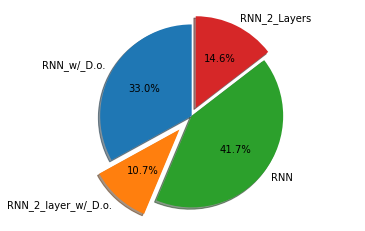

In [102]:
explode = (0., 0.2, 0, 0.1)  # only "explode" the 2nd slice (i.e. 'Hogs')

fig1, ax1 = plt.subplots()
ax1.pie(sizes, explode=explode, labels=labels, autopct='%1.1f%%',
        shadow=True, startangle=90)
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

plt.show()

In [110]:
predictions_05_18 = []
for zipcode in df_time_series.columns:
    predictions_05_18.append(best_model_dict[zipcode][1])

In [111]:
len(predictions_05_18)

103

Adding our best predictions to the Nevada DataFrame

In [122]:
df_time_series.loc['2018-05-01_pred'] = predictions_05_18


/Users/ferityikar/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
<ipython-input-122-025623a86f9b>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_time_series.loc['2018-05-01_pred'] = predictions_05_18


In [123]:
df_time_series

,95804,95817,95813,95785,95819,95770,95806,95790,95799,95844,...,95919,95794,399666,95760,95916,95891,95820,95917,95893,95851
1996-04-01 00:00:00,102500.000000,106800.000000,165100.00000,185700.00000,144000.000,122800.000000,95800.000000,148000.000,118900.000,157300.000,...,116800.00000,170900.0000,196000.0000,153200.00000,184200.00000,299200.0000,166100.0000,293200.000000,562400.00,176400.00000
1996-05-01 00:00:00,102500.000000,107000.000000,164500.00000,186300.00000,143500.000,122800.000000,95800.000000,147800.000,119000.000,156000.000,...,117000.00000,170800.0000,196000.0000,153700.00000,185000.00000,299600.0000,166600.0000,293200.000000,562800.00,176300.00000
1996-06-01 00:00:00,102500.000000,107200.000000,164000.00000,186900.00000,143100.000,122700.000000,95800.000000,147600.000,119000.000,154700.000,...,117200.00000,170700.0000,195900.0000,154100.00000,185800.00000,299900.0000,167300.0000,293200.000000,562700.00,176100.00000
1996-07-01 00:00:00,102600.000000,107400.000000,163500.00000,187400.00000,142700.000,122700.000000,95900.000000,147300.000,119100.000,153500.000,...,117400.00000,170700.0000,195700.0000,154400.00000,186400.00000,300200.0000,167900.0000,293200.000000,562400.00,176000.00000
1996-08-01 00:00:00,102700.000000,107600.000000,163200.00000,187700.00000,142400.000,122700.000000,96100.000000,147100.000,119200.000,152600.000,...,117600.00000,170700.0000,195400.0000,154700.00000,186900.00000,300500.0000,168600.0000,293200.000000,562300.00,175900.00000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2018-01-01 00:00:00,200700.000000,201500.000000,330700.00000,407300.00000,294300.000,234600.000000,189200.000000,303500.000,243700.000,294100.000,...,270000.00000,316500.0000,315500.0000,299900.00000,449500.00000,642500.0000,317600.0000,201600.000000,2121300.00,350400.00000
2018-02-01 00:00:00,203500.000000,204000.000000,334600.00000,410400.00000,297400.000,237200.000000,191700.000000,306700.000,246300.000,296900.000,...,275600.00000,319500.0000,319500.0000,302500.00000,450100.00000,653800.0000,323400.0000,207000.000000,2153600.00,353000.00000
2018-03-01 00:00:00,206600.000000,206700.000000,338800.00000,413700.00000,300200.000,239800.000000,194500.000000,309800.000,249500.000,299400.000,...,282100.00000,322400.0000,323600.0000,305700.00000,451100.00000,666000.0000,334700.0000,216500.000000,2167100.00,356000.00000
2018-04-01 00:00:00,209300.000000,208600.000000,342000.00000,416100.00000,302400.000,241900.000000,196600.000000,312200.000,252000.000,300800.000,...,286000.00000,324700.0000,326600.0000,307800.00000,455300.00000,672600.0000,344300.0000,222800.000000,2161900.00,357200.00000


In [126]:
investment_return = {}
for i in df_time_series.columns:
    investment_return[i] = (df_time_series[i][-1]-df_time_series[i][-2])/df_time_series[i][-2]

In [140]:
investment_return = dict(sorted(investment_return.items(), key=lambda item: item[1]))
investment_return


{95800: -0.6742991606714628,
 95803: -0.6494240172655453,
 95806: -0.6493513558621566,
 95804: -0.6123399799928333,
 95817: -0.6109500089884947,
 95911: -0.5999067429383712,
 95932: -0.5977889264990329,
 95909: -0.5939241231566361,
 95815: -0.5902021884233853,
 95931: -0.5887560566322901,
 95935: -0.5854965439334288,
 95838: -0.5818566524621213,
 95771: -0.580677253763089,
 399673: -0.5726413963475651,
 95852: -0.5670487002077224,
 95818: -0.5577714066159251,
 95811: -0.5536213600852272,
 95816: -0.5464916389943074,
 95770: -0.5433574695121951,
 95798: -0.5432109375,
 95912: -0.5388096816976128,
 95841: -0.5357096220152326,
 95826: -0.5301508402394107,
 95805: -0.524225871566556,
 95799: -0.523719742063492,
 95788: -0.5199503322963801,
 95824: -0.518330780411449,
 399671: -0.516835218910964,
 95845: -0.5151362232289951,
 95754: -0.5105418929354324,
 95843: -0.5066034170994065,
 95917: -0.5026651565305207,
 95940: -0.5021518020564169,
 95792: -0.49526765625,
 95914: -0.49519775324587506

In [151]:
list = []
for i in investment_return.keys():
    list.append(i)
best_5_investments = list[-5:]

In [152]:
best_5_investments

[95775, 399672, 95744, 95866, 399665]

In [156]:
investment_chart_data = df_time_series[best_5_investments][-12:]
investment_chart_data

,95775,399672,95744,95866,399665
2017-06-01 00:00:00,184400.000,377900.00000,281800.00000,270700.00000,270800.0000
2017-07-01 00:00:00,186300.000,381300.00000,284300.00000,272300.00000,273800.0000
2017-08-01 00:00:00,188500.000,384400.00000,287000.00000,274700.00000,276600.0000
2017-09-01 00:00:00,190600.000,388200.00000,290100.00000,278200.00000,280400.0000
2017-10-01 00:00:00,192600.000,392900.00000,294100.00000,282100.00000,285200.0000
2017-11-01 00:00:00,194400.000,397700.00000,297300.00000,285800.00000,289000.0000
2017-12-01 00:00:00,196100.000,402200.00000,300900.00000,290300.00000,292000.0000
2018-01-01 00:00:00,197600.000,406300.00000,304400.00000,294400.00000,294800.0000
2018-02-01 00:00:00,200200.000,410300.00000,307500.00000,297700.00000,297200.0000
2018-03-01 00:00:00,204300.000,416000.00000,310200.00000,300600.00000,299500.0000


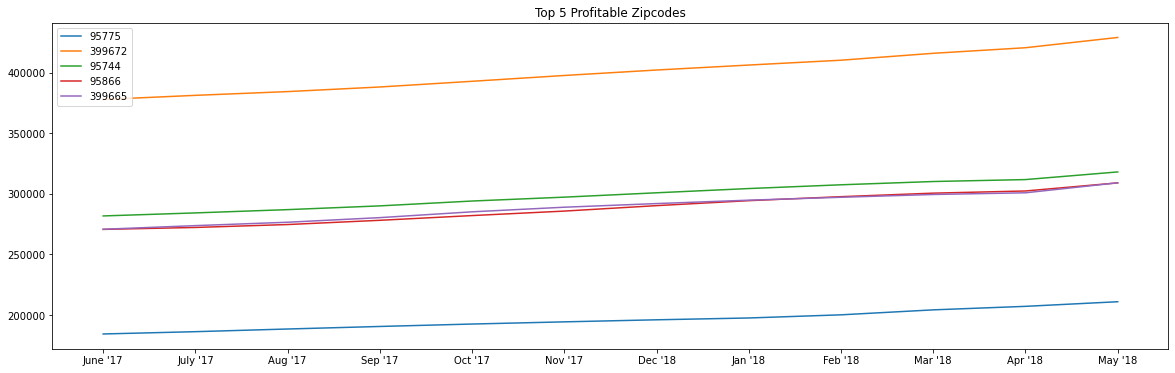

<Figure size 432x288 with 0 Axes>

In [179]:
months = ["June '17", "July '17","Aug '17","Sep '17","Oct '17","Nov '17","Dec '18","Jan '18","Feb '18","Mar '18","Apr '18", "May '18"]
fig, ax = plt.subplots(figsize=(20,6))
fig = plt.figure()

ax.plot(months, investment_chart_data[95775])
ax.plot(months, investment_chart_data[399672])
ax.plot(months, investment_chart_data[95744])
ax.plot(months, investment_chart_data[95866])
ax.plot(months, investment_chart_data[399665])



ax.set_title('Top 5 Profitable Zipcodes')
ax.legend(['95775','399672','95744','95866','399665'], loc=('upper left'));
